In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import shap


/Users/ryanshea/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First we will import and clean the data.

The pitch types have been reassigned so a fastball is 1, sinker is 2, slider is 3, and changeup is 4.

The result or 'type' changed so X is 0, strike is 1, and ball is 2.

Right-handed hitters are now 0 and left-handed hitters are 1.

In [17]:
data.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [21]:
data = pd.read_csv('savant_data.csv')


df = data[['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_y', \
    'release_pos_z', 'zone', 'stand', 'type', 'balls', 'strikes', \
        'effective_speed', 'release_spin_rate', 'release_extension', 'spin_axis', 'events']] # Relevant columns

df = df.dropna()


df['pitch_type'] = df['pitch_type'].replace({'FF' : 1, 'SI': 2, 'SL' : 3, 'CH' : 4})
df['type'] = df['type'].replace({'X' : 0, 'S' : 1, 'B' : 2})
df['stand'] = df['stand'].replace({'R' : 0, 'L' : 1})
df['pitch_type'] = df['pitch_type'].astype(int)


df.head()

,pitch_type,release_speed,release_pos_x,release_pos_y,release_pos_z,zone,stand,type,balls,strikes,effective_speed,release_spin_rate,release_extension,spin_axis,events
0,4,89.8,3.19,54.53,4.92,8.0,0,0,0,1,89.1,1983.0,6.0,86.0,double
2,3,83.1,3.04,54.38,5.25,5.0,1,0,2,2,82.8,2636.0,6.1,292.0,field_out
7,4,86.3,3.10,54.15,4.94,14.0,0,0,1,1,86.2,1979.0,6.3,90.0,fielders_choice
10,3,82.1,3.01,54.87,5.11,13.0,1,1,1,2,80.8,2688.0,5.6,286.0,strikeout
14,2,92.9,3.16,54.25,5.13,12.0,0,2,3,1,92.7,2298.0,6.2,98.0,walk


In [20]:
df['events'].unique()

array(['double', 'field_out', 'fielders_choice', 'strikeout', 'walk',
       'home_run', 'single', 'grounded_into_double_play', 'hit_by_pitch',
       'force_out', 'field_error', 'sac_bunt', 'sac_fly', 'pickoff_1b',
       'caught_stealing_2b', 'triple'], dtype=object)

In [15]:
# Add an 'Executed' column to determine if the pitch was good or not
# If the pitch was good, the value is 1, otherwise 0
good_counts = ['0-1', '0-2', '1-2', '2-2']

def executed(row):
    if row['type'] == 2 and row['count'] in good_counts:
        return 1
    elif row['type'] == 1 and row['count'] not in good_counts:
        return 1
    elif row['type'] == 0:
        if 

df['executed'] = df.apply(executed, axis=1)
    


In [16]:
df

,pitch_type,release_speed,release_pos_x,release_pos_y,release_pos_z,zone,stand,type,effective_speed,release_spin_rate,release_extension,spin_axis,count,executed
0,4,89.8,3.19,54.53,4.92,8.0,0,0,89.1,1983.0,6.0,86.0,0-1,0
1,3,81.3,3.22,55.06,5.28,12.0,0,1,79.8,2624.0,5.4,289.0,0-0,1
2,3,83.1,3.04,54.38,5.25,5.0,1,0,82.8,2636.0,6.1,292.0,2-2,0
3,1,96.6,3.03,53.96,5.52,2.0,1,1,96.9,2422.0,6.5,137.0,2-1,1
4,1,95.7,3.13,53.95,5.21,1.0,1,1,95.8,2525.0,6.6,131.0,2-0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2461,1,93.9,3.22,54.68,5.35,4.0,0,1,92.4,2334.0,5.8,133.0,2-2,0
2462,3,78.4,3.04,54.93,5.31,13.0,0,2,76.7,2561.0,5.6,282.0,1-2,1
2463,1,91.1,3.32,54.74,5.19,12.0,0,2,89.6,2320.0,5.8,126.0,0-2,1
2464,3,77.0,3.32,55.12,5.15,8.0,0,1,75.4,2356.0,5.4,285.0,0-1,0


array(['0-1', '0-0', '2-2', '2-1', '2-0', '1-0', '1-1', '1-2', '0-2',
       '3-1', '3-0', '3-2'], dtype=object)

In [30]:
df2 = pd.DataFrame(df[['pitch_type']])

df2['release_speed'] = df['release_speed'].mean() - df['release_speed']

for col in df.columns[1:5]:
    df2[str(col)] = df[str(col)].mean() - df[col]

df2['zone'] = df['zone']
df2['stand'] = df['stand']
df2['type'] = df['type']
df2['balls'] = df['balls']
df2['strikes'] = df['strikes']

for col in df.columns[10:]:
    df2[col] = df[col].mean() - df[col]

df2_norm = (df2 - df2.min()) / (df2.max() - df2.min())
df2_norm['pitch_type'] = df2['pitch_type']
df2_norm.head()

,pitch_type,release_speed,release_pos_x,release_pos_y,release_pos_z,zone,stand,type,balls,strikes,effective_speed,release_spin_rate,release_extension,spin_axis
0,4,0.267913,0.515873,0.538462,0.906250,0.538462,0.0,0.0,0.000000,0.5,0.286136,0.666402,0.45,0.921986
1,3,0.532710,0.492063,0.283654,0.625000,0.846154,0.0,0.5,0.000000,0.0,0.560472,0.157268,0.75,0.202128
2,3,0.476636,0.634921,0.610577,0.648437,0.307692,1.0,0.0,0.666667,1.0,0.471976,0.147736,0.40,0.191489
3,1,0.056075,0.642857,0.812500,0.437500,0.076923,1.0,0.5,0.666667,0.5,0.056047,0.317712,0.20,0.741135
4,1,0.084112,0.563492,0.817308,0.679688,0.000000,1.0,0.5,0.666667,0.0,0.088496,0.235902,0.15,0.762411


Let's plot each column in the dataframe in order to make sure that everything looks ready to use.

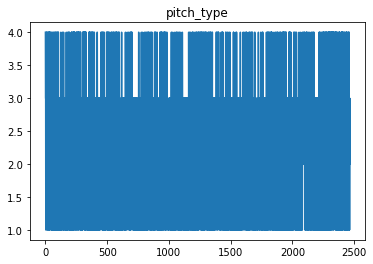

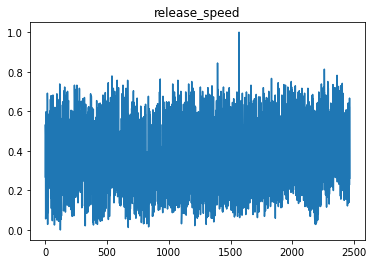

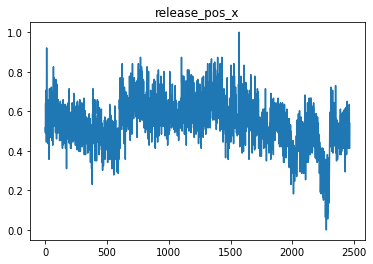

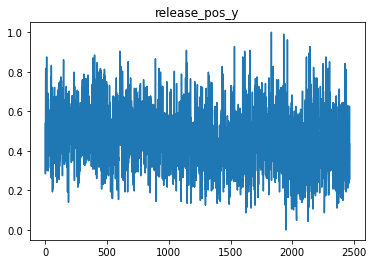

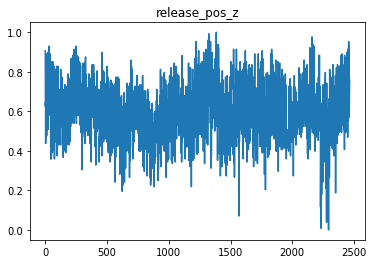

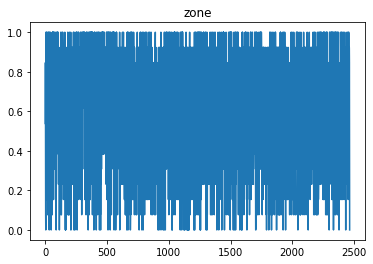

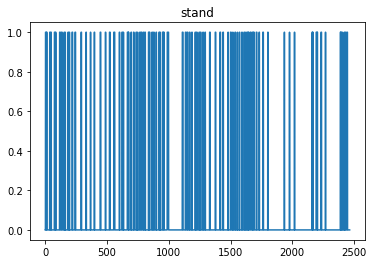

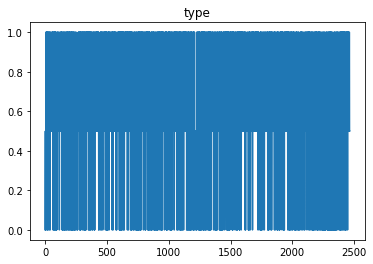

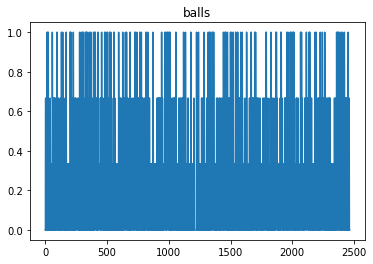

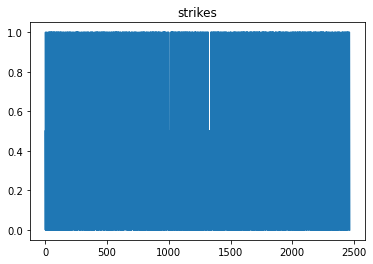

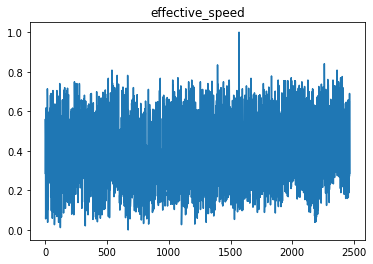

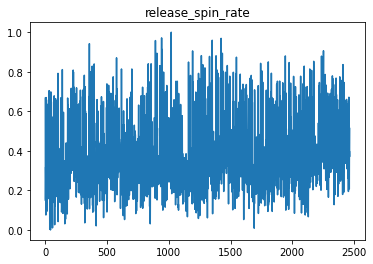

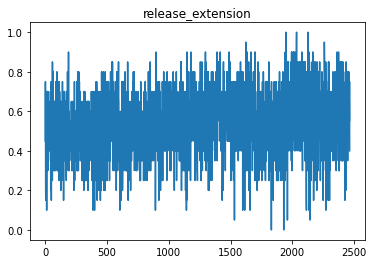

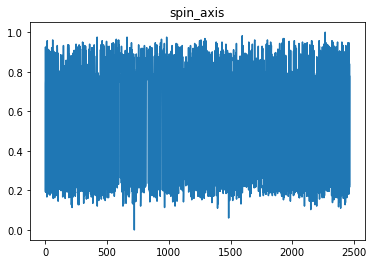

In [32]:

for col in df2_norm.columns:
    plt.plot(df2_norm[col])
    plt.title(col)
    plt.show()

# Neural Networks


Test 1:
Training: 0.9863083164300203
Testing:  0.9756592292089249


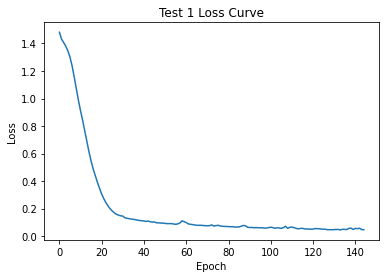

X does not have valid feature names, but MLPClassifier was fitted with feature names
  0%|          | 0/493 [00:00<?, ?it/s]X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
  0%|          | 1/493 [00:00<02:00,  4.08it/s]X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
  0%|          | 2/493 [00:00<01:46,  4.61it/s]X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
  1%|          | 3/493 [00:00<01:32,  5.30it/s]X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
  1%|          | 4/493 [00:00<01:25,  5.70it/s]X does n

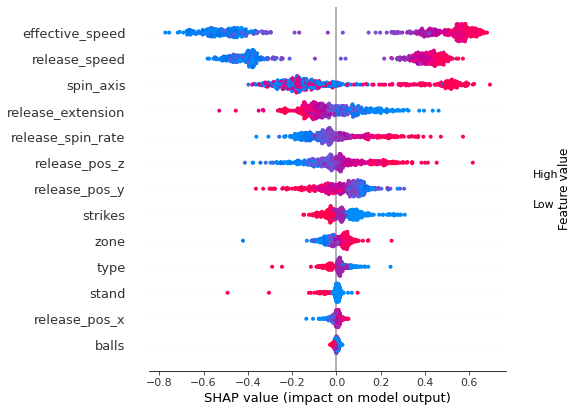



Average Train: 0.9863083164300203
Average Test:  0.9756592292089249


In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split


x, y = df2_norm.drop(['pitch_type'], axis=1), df2_norm['pitch_type']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

avg_train = 0
avg_test =  0
num_tests = 1

for test in range(num_tests):
    np.random.seed(test)
    mlp = MLPClassifier(hidden_layer_sizes=(13, 13**2, 13, 10), activation='relu', max_iter=500) 

    mlp.fit(x_train, y_train)
    print("\nTest %i:" % (test + 1))
    print("Training:", mlp.score(x_train, y_train))
    print("Testing: ", mlp.score(x_test, y_test))
    avg_train += mlp.score(x_train, y_train)
    avg_test += mlp.score(x_test, y_test)
    plt.plot(mlp.loss_curve_)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Test %i Loss Curve" % (test + 1))
    plt.show()

    # Use Shap explainer to interpret values in the test set:
    X_train_summary = shap.kmeans(x_train, 10)
    explainer = shap.KernelExplainer(mlp.predict, X_train_summary)
    shap_values = explainer.shap_values(x_test)

    # Plot the Shap values:
    shap.summary_plot(shap_values, x_test)



print("\n\nAverage Train:", str(avg_train / num_tests))
print("Average Test: ", str(avg_test / num_tests))

Using all of these inputs, several stand out. First of all, the effective speed / release speed being the most important values makes sense because of the fact that velocity is the largest difference between pitches. Spin axis being third also makes sense because it is completely different depending on the type of pitch it is.

Extension is intresting as well because it might show decide if Sale gets further out (similar to release_pos_z) it indicates a certain type of pitch. If I had to guess the feature value is higher for the fastballs because he's getting more out in front while his other pitches might be a little bit further behind it.

Strikes is a relatively strong predictor as well because of the fact that he might throw more sliders in a 2 strike count



Test 1:
Training: 0.9756592292089249
Testing:  0.9634888438133874


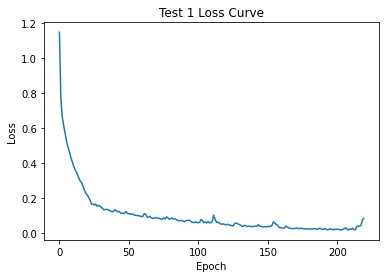

X does not have valid feature names, but MLPClassifier was fitted with feature names
  0%|          | 0/493 [00:00<?, ?it/s]X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
  0%|          | 1/493 [00:00<01:57,  4.18it/s]X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
  0%|          | 2/493 [00:00<01:39,  4.93it/s]X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
  1%|          | 3/493 [00:00<01:26,  5.66it/s]X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
  1%|          | 4/493 [00:00<01:19,  6.14it/s]X does n

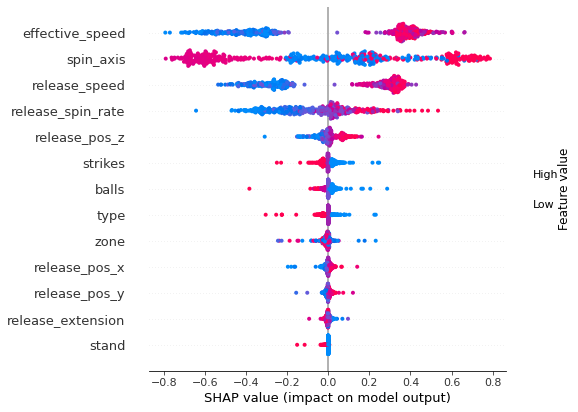



Average Train: 0.9756592292089249
Average Test:  0.9634888438133874


In [34]:
x, y = df2.drop(['pitch_type'], axis=1), df['pitch_type']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

avg_train = 0
avg_test =  0
num_tests = 1

for test in range(num_tests):
    np.random.seed(test)
    mlp = MLPClassifier(hidden_layer_sizes=(13, 13**2, 13, 10), activation='relu', max_iter=500) 

    mlp.fit(x_train, y_train)
    print("\nTest %i:" % (test + 1))
    print("Training:", mlp.score(x_train, y_train))
    print("Testing: ", mlp.score(x_test, y_test))
    avg_train += mlp.score(x_train, y_train)
    avg_test += mlp.score(x_test, y_test)
    plt.plot(mlp.loss_curve_)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Test %i Loss Curve" % (test + 1))
    plt.show()

    # Use Shap explainer to interpret values in the test set:
    X_train_summary = shap.kmeans(x_train, 10)
    explainer = shap.KernelExplainer(mlp.predict, X_train_summary)
    shap_values = explainer.shap_values(x_test)

    # Plot the Shap values:
    shap.summary_plot(shap_values, x_test)



print("\n\nAverage Train:", str(avg_train / num_tests))
print("Average Test: ", str(avg_test / num_tests))

In [ ]:
mlp.feature_names_in_

According to the SHAP values, Spin axis, spin rate and effective speed are the most important values when it comes to neural networks.

Now I will run the same neural network with fewer parameters to see if we can get comparable results from a simpler model.


Test 1 Loss Curve:
Training: 0.3859026369168357
Testing: 0.3772819472616633


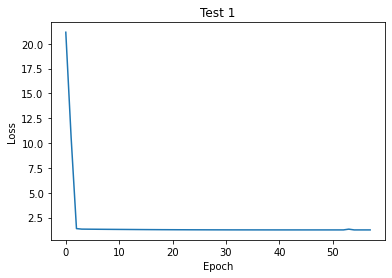



Average Train: 0.3859026369168357
Average Test:  0.3772819472616633


In [44]:
df2 = df[['pitch_type', 'release_speed', 'release_spin_rate', 'spin_axis']]


x, y = df2.drop(['pitch_type'], axis=1), df2['pitch_type']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


avg_train = 0
avg_test =  0
num_tests = 1

for test in range(num_tests):
    np.random.seed(test + 5)
    mlp = MLPClassifier(hidden_layer_sizes=(13, 13**2, 13, 10), activation='relu', max_iter=500)
    mlp.fit(x_train, y_train)
    print("\nTest %i Loss Curve:" % (test + 1))
    print("Training:", mlp.score(x_train, y_train))
    print("Testing:", mlp.score(x_test, y_test))
    avg_train += mlp.score(x_train, y_train)
    avg_test += mlp.score(x_test, y_test)
    plt.plot(mlp.loss_curve_)
    plt.title("Test %i" % (test + 1))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # Use Shap explainer to interpret values in the test set:
    #X_train_summary = shap.kmeans(x_train, 10)
    #explainer = shap.KernelExplainer(mlp.predict, X_train_summary)
    #shap_values = explainer.shap_values(x_test)

    # Plot the Shap values:
    #shap.summary_plot(shap_values, x_test)



print("\n\nAverage Train:", str(avg_train / num_tests))
print("Average Test: ", str(avg_test / num_tests))

In [ ]:
shap.force_plot(explainer.expected_value, shap_vals)

The neural network does not do as well when there are fewer parameters.

Now let's look at a Support Vector Classifier instead.

# Support Vector Machine for Classification

In [42]:
from sklearn.svm import SVC
np.random.seed(123)
x, y = df.drop(['pitch_type'], axis=1), df['pitch_type']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


svm = SVC(C=1e5, kernel='rbf', probability=True) # Raise cost of misclassification
svm.fit(x_train, y_train)

print(svm.score(x_train, y_train))
print(svm.score(x_test, y_test))


0.992393509127789
0.9918864097363083


X does not have valid feature names, but SVC was fitted with feature names
  0%|          | 0/493 [00:00<?, ?it/s]X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
  0%|          | 1/493 [00:00<03:11,  2.57it/s]X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
  0%|          | 2/493 [00:00<02:50,  2.87it/s]X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
  1%|          | 3/493 [00:01<02:44,  2.98it/s]X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
  1%|          | 4/493 [00:01<02:43,  2.99it/s]X does not have valid feature names, but SVC was fitted with feature names
X does not have valid f

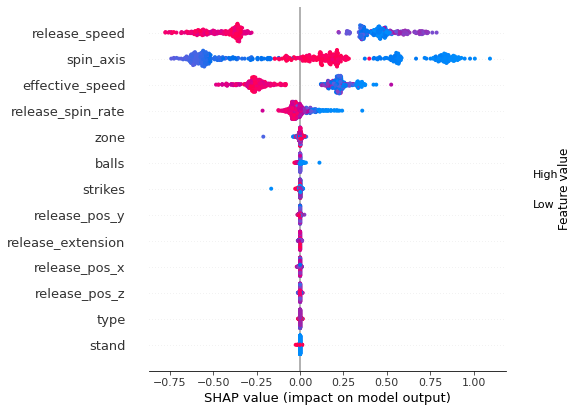

In [43]:
# df


X_train_summary = shap.kmeans(x_train, 13)
explainer = shap.KernelExplainer(svm.predict, X_train_summary)
shap_values = explainer.shap_values(x_test)


shap.summary_plot(shap_values, x_test)

In [45]:
from sklearn.svm import SVC
np.random.seed(123)
x, y = df2.drop(['pitch_type'], axis=1), df2['pitch_type']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


svm = SVC(C=1e5, kernel='rbf', probability=True) # Raise cost of misclassification
svm.fit(x_train, y_train)

print(svm.score(x_train, y_train))
print(svm.score(x_test, y_test))


0.9929006085192698
0.9959432048681541


In [37]:
from sklearn.svm import SVC
np.random.seed(123)
x, y = df2_norm.drop(['pitch_type'], axis=1), df2_norm['pitch_type']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


svm = SVC(C=1e5, kernel='rbf', probability=True) # Raise cost of misclassification
svm.fit(x_train, y_train)

print(svm.score(x_train, y_train))
print(svm.score(x_test, y_test))


1.0
0.9797160243407708


A perfect training score could imply overfitting here. The test accuracy drops down a decent amount, where roughtly 1 in 50 are misclassified.

X does not have valid feature names, but SVC was fitted with feature names
  0%|          | 0/493 [00:00<?, ?it/s]X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
  0%|          | 1/493 [00:00<07:55,  1.03it/s]X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
  0%|          | 2/493 [00:01<07:28,  1.09it/s]X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
  1%|          | 3/493 [00:02<07:17,  1.12it/s]X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
  1%|          | 4/493 [00:03<07:11,  1.13it/s]X does not have valid feature names, but SVC was fitted with feature names
X does not have valid f

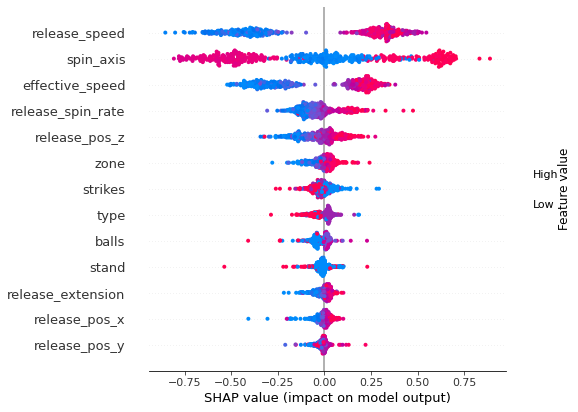

In [39]:
# df2_norm


# X_train_summary = shap.kmeans(x_train, 13)
# explainer = shap.KernelExplainer(svm.predict, X_train_summary)
# shap_values = explainer.shap_values(x_test)
# # Make it ignore the warning:
shap.force_plot(explainer.expected_value, shap_values)


# shap.summary_plot(shap_values, x_test)

In [1]:
shap.force_plot(explainer.expected_value, shap_values)

NameError: name 'shap' is not defined

Release speed, spin_axis, effective speed and spin rate are the most important features in the SVM. Release speed and effective speed are in a way redundant because of the fact that they are almost always very close to each other.

Again, we will try to simplify this with the second dataframe with fewer features.

In [ ]:
np.random.seed(123)
x, y = df2.drop(['pitch_type'], axis=1), df2['pitch_type']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


svm = SVC(C=1e5, kernel='rbf', probability=True)
svm.fit(x_train, y_train)

print(svm.score(x_train, y_train))
print(svm.score(x_test, y_test))

In [ ]:
# Use Shap explainer to interpret values in the test set:
X_train_summary = shap.kmeans(x_train, 3)
explainer = shap.KernelExplainer(svm.predict, X_train_summary)
shap_values = explainer.shap_values(x_test)

# Plot the Shap values:
shap.summary_plot(shap_values, x_test)

The SVC is a more effective model in classifying the pitch type than the Neural network. Here is an example of a few pitches, and the model correctly classifying the pitch type based on release speed, spin rate, and the spin axis.

We will look to find a misclassification and try to determine why.

In [ ]:
df2.head(15)

In [ ]:
def warn(*args, **kwargs):
    pass

warnings.warn = warn



[print("Should predict [%i]" % df2['pitch_type'][i], svm.predict([[df2['release_speed'][i], df2['release_spin_rate'][i], df2['spin_axis'][i]]])) for i in range(15)]

In [ ]:
pred = svm.predict_proba(x_train)

In [ ]:
pd.set_option('display.float_format', lambda x: '%.10f' % x)

count = 1
for i in pred[0:14]:
    print("Pitch", count)
    count += 1
    print(["%.10f" % j for j in i])


In [6]:
row = 0

X_train_summary = shap.kmeans(x_train, 3)


explainer = shap.KernelExplainer(svm.predict, X_train_summary)
shap_values = explainer.shap_values(x_test)

NameError: name 'x_train' is not defined

In [5]:
shap.initjs()

row = 27

shap.force_plot(explainer.expected_value, shap_values[row], x_test.iloc[row])


NameError: name 'explainer' is not defined

In [ ]:
# release_speed, release_spin_rate, spin_axis

print(svm.predict([[76.5, 2507, 289]]))

Of the first 15 pitches in the dataframe, it classified all but 1 correctly: the first pitch was a slider but the model classified it as a sinker. This is most likely because it was a harder slider (at 89.9 MPH) where the other parameters profile similar to his sinker. This can be attributed to two different reasons, because he barely throws sinkers which leads to a small sample size, and becuase it is using the simpler SVM model in which it only takes in 3 features as opposed to the more complex model (which takes in 13).